<center><h1>NASA Meteorite Analysis</h1></center>

## Importing Relavent Libraries

In [1]:
# Data
import pandas as pd
import numpy as np
import warnings

# Visualizations
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly.express as px

# Machine Learning
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor

dataset = ("https://www.kaggle.com/datasets/sujaykapadnis/meteorites-dataset/data")

df = pd.read_csv("meteorites.csv")
df.head()

name   id name_type        class      mass  fall    year       lat  \
0    Aachen    1     Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2     Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6     Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10     Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370     Valid           L6     780.0  Fell  1902.0 -33.16667   

        long           geolocation  
0    6.08333     (50.775, 6.08333)  
1   10.23333  (56.18333, 10.23333)  
2 -113.00000    (54.21667, -113.0)  
3  -99.90000     (16.88333, -99.9)  
4  -64.95000   (-33.16667, -64.95)

In [2]:
df.tail()

name     id name_type                 class    mass   fall  \
45711  Zillah 002  31356     Valid               Eucrite   172.0  Found   
45712      Zinder  30409     Valid  Pallasite, ungrouped    46.0  Found   
45713        Zlin  30410     Valid                    H4     3.3  Found   
45714   Zubkovsky  31357     Valid                    L6  2167.0  Found   
45715  Zulu Queen  30414     Valid                  L3.7   200.0  Found   

         year       lat       long             geolocation  
45711  1990.0  29.03700   17.01850       (29.037, 17.0185)  
45712  1999.0  13.78333    8.96667     (13.78333, 8.96667)  
45713  1939.0  49.25000   17.66667       (49.25, 17.66667)  
45714  2003.0  49.78917   41.50460     (49.78917, 41.5046)  
45715  1976.0  33.98333 -115.68333  (33.98333, -115.68333)

#### Data Description

In [3]:
data_description = {
    "name": "Meteroite's name", 
    "id": "Numerical meteorite ID number", 
    "name_type": "Name type either valid or relict", 
    "class": "Class of the meteorite", 
    "mass": "Mass of the meteorite in grams (g)", 
    "fall": "Binary, the meteorite either fell or was found", 
    "year": "Year that the meteorite was discovered", 
    "lat": "Latitude of the meteorite", 
    "long": "Longitude of the meteorite", 
    "geolocation": "Aggregate of both latitude and longitude"
}

data_card = pd.DataFrame(list(data_description.items()), columns=['Features', 'Descrition'],)

print("\033[1m                Data Dictionary \033[0m")
data_card

                Data Dictionary 


Features                                      Descrition
0         name                                Meteroite's name
1           id                   Numerical meteorite ID number
2    name_type                Name type either valid or relict
3        class                          Class of the meteorite
4         mass              Mass of the meteorite in grams (g)
5         fall  Binary, the meteorite either fell or was found
6         year          Year that the meteorite was discovered
7          lat                       Latitude of the meteorite
8         long                      Longitude of the meteorite
9  geolocation        Aggregate of both latitude and longitude

## Exploratory Data Analysis
Understanding the nature of features in this dataset.

#### Check for duplicates

In [4]:
def duplicates(df):
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]

    total_duplicates = before - after
    print(f"There are a total of {total_duplicates} duplicates in this dataset.")
    
duplicates(df)

There are a total of 0 duplicates in this dataset.


#### Check For Proper Data Types

In [5]:
# Data types are looking solid
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   name_type    45716 non-null  object 
 3   class        45716 non-null  object 
 4   mass         45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   lat          38401 non-null  float64
 8   long         38401 non-null  float64
 9   geolocation  38401 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 3.5+ MB


#### Valid or Relict?

Total Valid Count:  45641 
Total Relict Count:  75


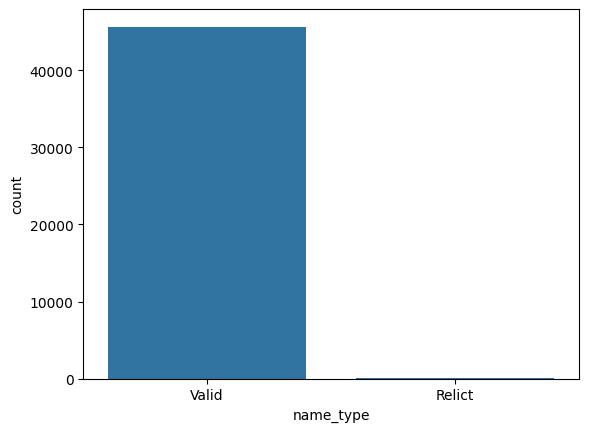

name     id name_type                   class  mass  \
5219                 Brunflo   5157    Relict                Relict H   NaN   
6818     David Glacier 92308   6614    Relict  Chondrite-fusion crust   1.7   
12640                   Gove  52859    Relict             Relict iron   0.0   
15947          Gullhögen 001  44889    Relict               Relict OC   NaN   
17756  LaPaz Icefield 031037  35780    Relict            Fusion crust   0.1   
...                      ...    ...       ...                     ...   ...   
31073         Österplana 060  56159    Relict               Relict OC   0.0   
31074         Österplana 061  56160    Relict               Relict OC   0.0   
31075         Österplana 062  56161    Relict               Relict OC   0.0   
31076         Österplana 063  56162    Relict               Relict OC   0.0   
31077         Österplana 064  56163    Relict               Relict OC   0.0   

        fall    year       lat       long             geolocation  
5219   Found  1980.0  63.11667   14.28333    (63.11667, 14.28333)  
6818   Found  1992.0 -75.31667  162.00000      (-75.31667, 162.0)  
12640  Found  1979.0 -12.26333  136.83833  (-12.26333, 136.83833)  
15947  Found  2000.0  58.38333   13.80000        (58.38333, 13.8)  
17756  Found  2003.0       NaN        NaN                     NaN  
...      ...     ...       ...        ...                     ...  
31073  Found  2009.0  58.58333   13.43333    (58.58333, 13.43333)  
31074  Found  2009.0  58.58333   13.43333    (58.58333, 13.43333)  
31075  Found  2010.0  58.58333   13.43333    (58.58333, 13.43333)  
31076  Found  2010.0  58.58333   13.43333    (58.58333, 13.43333)  
31077  Found  2011.0  58.58333   13.43333    (58.58333, 13.43333)  

[75 rows x 10 columns]

<Figure size 640x480 with 0 Axes>

In [6]:
# A relict meteorite is an old meteorite that has undergone significant chemical changes since it has landed on Earth
print('Total Valid Count: ',df.name_type.value_counts()['Valid'], 
      '\nTotal Relict Count: ', df.name_type.value_counts()['Relict'])

sns.countplot(x='name_type',data=df)
plt.show()
plt.clf()

# Group the 
grouped_type = df.groupby('name_type')
relict = grouped_type.get_group('Relict')
relict

In [7]:
# Not surprisingling, all relicts are classified as found
relict_found = [relict.name_type.count(), relict.fall.count()]
print(f"There are {relict_found[0]} relicts in this dataset, and {(relict_found[1]/relict_found[0])*100}% of them are classified as Found.")

There are 75 relicts in this dataset, and 100.0% of them are classified as Found.


Taking a look at the geolocations, it appears that the relicts are distributed close to each other, let's make a global plot to visualize where the relicts are found.

In [8]:
warnings.filterwarnings("ignore") 

relict.mass = relict.mass.replace([' ', 0.0], np.NaN)
relict.mass = relict.mass.fillna(relict.mass.mean()) 

relict_figure = px.scatter_geo(
    relict,
    lat='lat',
    lon='long',
    title='Distribution of Relict Meteorites',
    projection='natural earth', 
    hover_name='name', 
    size='mass', 
    template='plotly_dark',
)

relict_figure.show()
warnings.resetwarnings()

It looks like the relicts are all grouped to a few locations, this could indicated that these location are ideal for preserving meteorites for long periods of time. This could be due to things such as soil type, environmental conditions, low winds (low erosion), or year around ice condition (Anatartica and Northern Baltics are shown here).

#### Mass
Let's see just how big some of the largest meteorites are in comparison to rest.

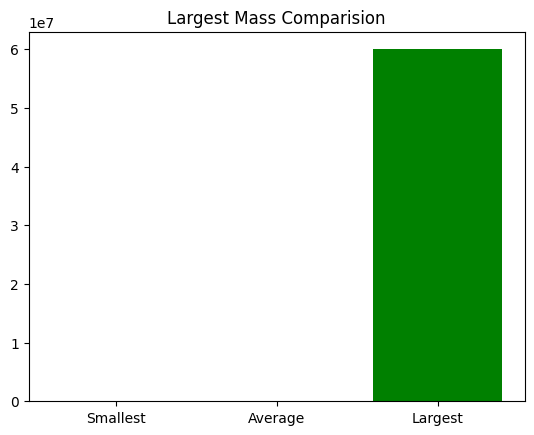

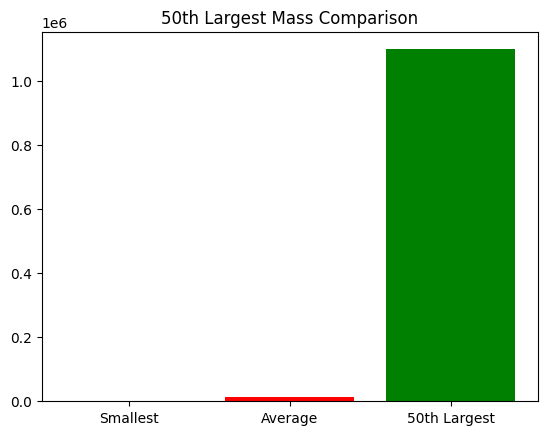

In [9]:
sorted_mass = df.sort_values(by='mass', ascending=False)
sorted_mass.mass.replace(0.0, np.NaN, inplace=True)
sorted_mass.mass = sorted_mass.mass.dropna()

top_50_mass = sorted_mass['mass'].head(50).tolist()
mass_50th_largest = top_50_mass[-1]

average_mass = df.mass.mean()
smallest_mass = sorted_mass['mass'].min() # smallest
largest_mass = sorted_mass['mass'].max() # largest

# Clearly there are some very large masses, let's look at the 50th largest to get a better idea
mass_values = [smallest_mass,average_mass,largest_mass]
new_mass_values = [smallest_mass,average_mass,mass_50th_largest]
mass_names = ['Smallest', 'Average', 'Largest']
new_mass_names = ['Smallest', 'Average', '50th Largest']

plt.bar(mass_names, mass_values, color=['blue', 'red', 'green'])
plt.title("Largest Mass Comparision")
plt.show()
plt.clf()

plt.bar(new_mass_names, new_mass_values, color=['blue', 'red', 'green'])
plt.title("50th Largest Mass Comparison")
plt.show()

#### Class Type

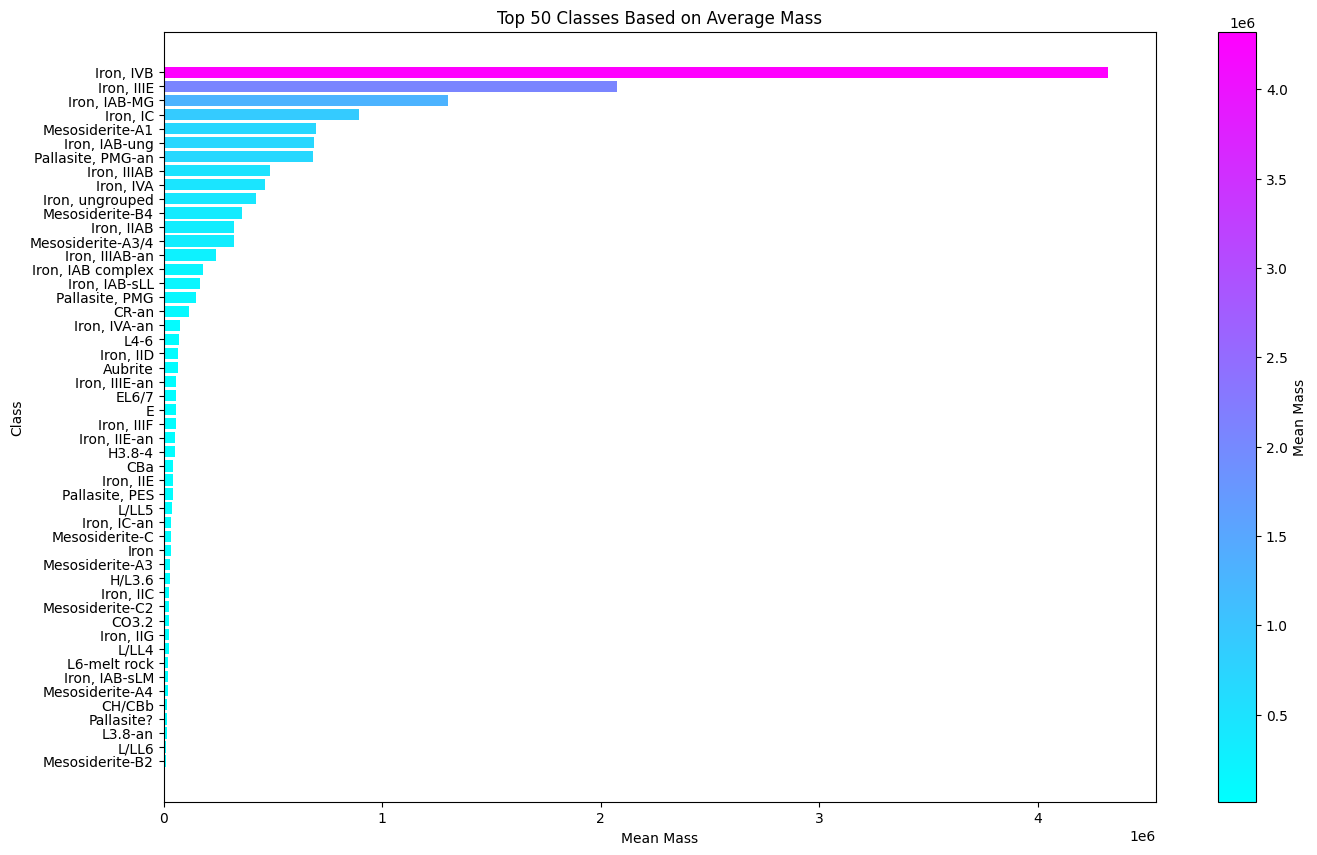

In [10]:
# Assuming 'df' is your DataFrame and it's already defined
class_mean_mass = df.groupby('class')['mass'].mean().reset_index()
top_50_classes = class_mean_mass.nlargest(50, 'mass')

plt.figure(figsize=(16, 10))
norm = Normalize(vmin=top_50_classes['mass'].min(), vmax=top_50_classes['mass'].max())
colors = plt.cm.cool(norm(top_50_classes['mass']))

# Create an Axes instance
ax = plt.gca()

# Visualize the 50 heaviest classes
bars = ax.barh(top_50_classes['class'], top_50_classes['mass'], color=colors)

# Create a ScalarMappable with the same normalization and colormap
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])  # we need to set an empty array to avoid a warning

# Create the colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Mean Mass')

plt.xlabel('Mean Mass')
plt.ylabel('Class')
plt.title('Top 50 Classes Based on Average Mass')

ax.invert_yaxis()
plt.show()


#### Fell or Found?
This is a very important feature to comprehend. This tells us that NASA does not know when the majority of meteorites impacted the Earth and that they only know when it was found. This is a problem for machine learning algorithms that want to effectively predict how many impacts will happen in the future. If we don't know the actual rate of impacts per year, predictive modeling cannot effectively predict an impact number for the future, only an estimation for many meteorites will be discovered.

Total Fell Count:  1107 
Total Found Count:  44609


<Axes: xlabel='fall', ylabel='count'>

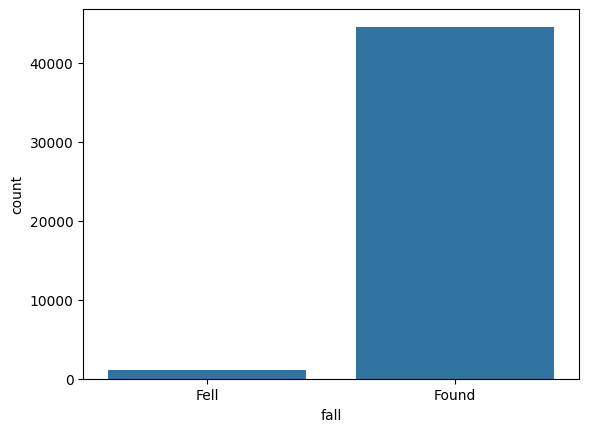

In [11]:
print('Total Fell Count: ',df.fall.value_counts()['Fell'], 
      '\nTotal Found Count: ', df.fall.value_counts()['Found'])

sns.countplot(x='fall',data=df)

#### General Time Series Analysis

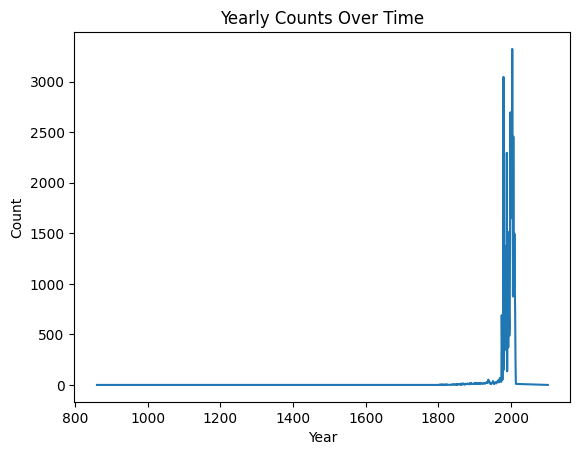

In [12]:
yearly_rates = df.year.value_counts() # count the amount of values for each year
yearly_rates = yearly_rates.sort_index()

plt.plot(yearly_rates.index, yearly_rates.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Counts Over Time')
plt.show()

This distribution is not surprising, the majority of meteorites recorded by NASA has occurred in the past half century as NASA was founded in 1958. However there appears to be a value that is in the future, let's take a closer look and reevaluate. 

In [13]:
print("The earliest meteorite recorded", yearly_rates.index.min())
print("The latest meteorite recorded", yearly_rates.index.max())

The earliest meteorite recorded 860.0
The latest meteorite recorded 2101.0


The Nōgata meteorite is indeed the earliest known meteorite that was found in Japan, however according to over a dozen different sources (including NASA), it was discovered in 861, not 860. The latest value however is 2101, which is in the future and needs to be addressed.

In [14]:
df.query("year == 860.0")

name     id name_type class   mass  fall   year     lat    long  \
704  Nogata  16988     Valid    L6  472.0  Fell  860.0  33.725  130.75   

          geolocation  
704  (33.725, 130.75)

In [15]:
df.at[704, 'year'] = 861.0 # redefine to the correct value
df.query("name == 'Nogata'")

name     id name_type class   mass  fall   year     lat    long  \
704  Nogata  16988     Valid    L6  472.0  Fell  861.0  33.725  130.75   

          geolocation  
704  (33.725, 130.75)

In [16]:
 # Sort the year column to be chronological
df_sorted_year = df.sort_values(by='year', ascending=False)

latest_5_years = df_sorted_year['year'].head(5)

# Let's check to make sure there is only 1 future value
print(latest_5_years)

30682    2101.0
194      2013.0
30730    2013.0
30763    2013.0
30774    2013.0
Name: year, dtype: float64


In [17]:
# Let's take a look at this meteorite and find out its actual discovery date, the geolocation is unknown too and will be
# addressed later 
df.query("year == 2101.0")

name     id name_type class  mass   fall    year  lat  \
30682  Northwest Africa 7701  57150     Valid   CK6  55.0  Found  2101.0  0.0   

       long geolocation  
30682   0.0  (0.0, 0.0)

In [18]:
# Northwest Africa 7701 was discovered in 2010, so just slight input error
df.at[30682, 'year'] = 2010.0 # redefine to the correct value
df.query("name == 'Northwest Africa 7701'")

name     id name_type class  mass   fall    year  lat  \
30682  Northwest Africa 7701  57150     Valid   CK6  55.0  Found  2010.0  0.0   

       long geolocation  
30682   0.0  (0.0, 0.0)

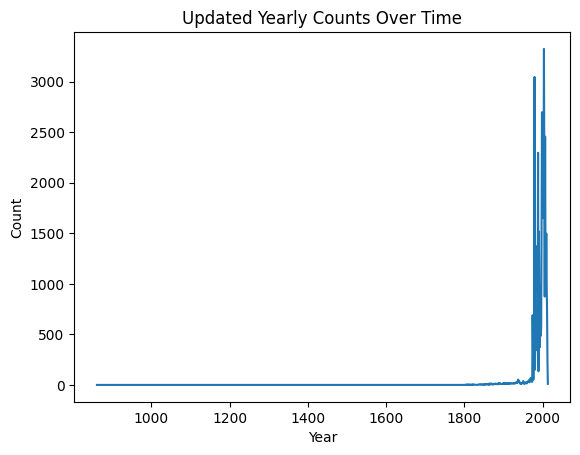

In [19]:
yearly_rates = df.year.value_counts() 
yearly_rates = yearly_rates.sort_index()

plt.plot(yearly_rates.index, yearly_rates.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Updated Yearly Counts Over Time')
plt.show()

#### Geospatial Data
The following creates an interactive map that displays the global distribution of metoeorites recorded by NASA where the size of the circles correspond to their respective mass in grams. In order for this animation to run, all null values in the mass column needs to be addressed. Filling each missing value with the total mean is the best course of action here for the EDA phase by defining a new dataframe so the original is unaffected for the time being.

In [20]:
animation_df = df 
animation_df.mass = animation_df.mass.replace([' ', 0.0], np.NaN)
animation_df.mass = animation_df.mass.fillna(animation_df.mass.mean()) 
animation_df = animation_df.sort_values(['year'])

fig = px.scatter_geo(
    animation_df,
    lat='lat',
    lon='long',
    title='Global Distribution of Meteorites',
    projection='natural earth', 
    hover_name='name', 
    size='mass', 
    template='plotly_dark',
    animation_frame='year'
)

fig.show()

## Handling Missing Data

In [21]:
# (Total rows, Total columns)
df.shape

(45716, 10)

In [22]:
# Check the total missing values for each feature
df.isnull().sum()

name              0
id                0
name_type         0
class             0
mass              0
fall              0
year            291
lat            7315
long           7315
geolocation    7315
dtype: int64

<Axes: >

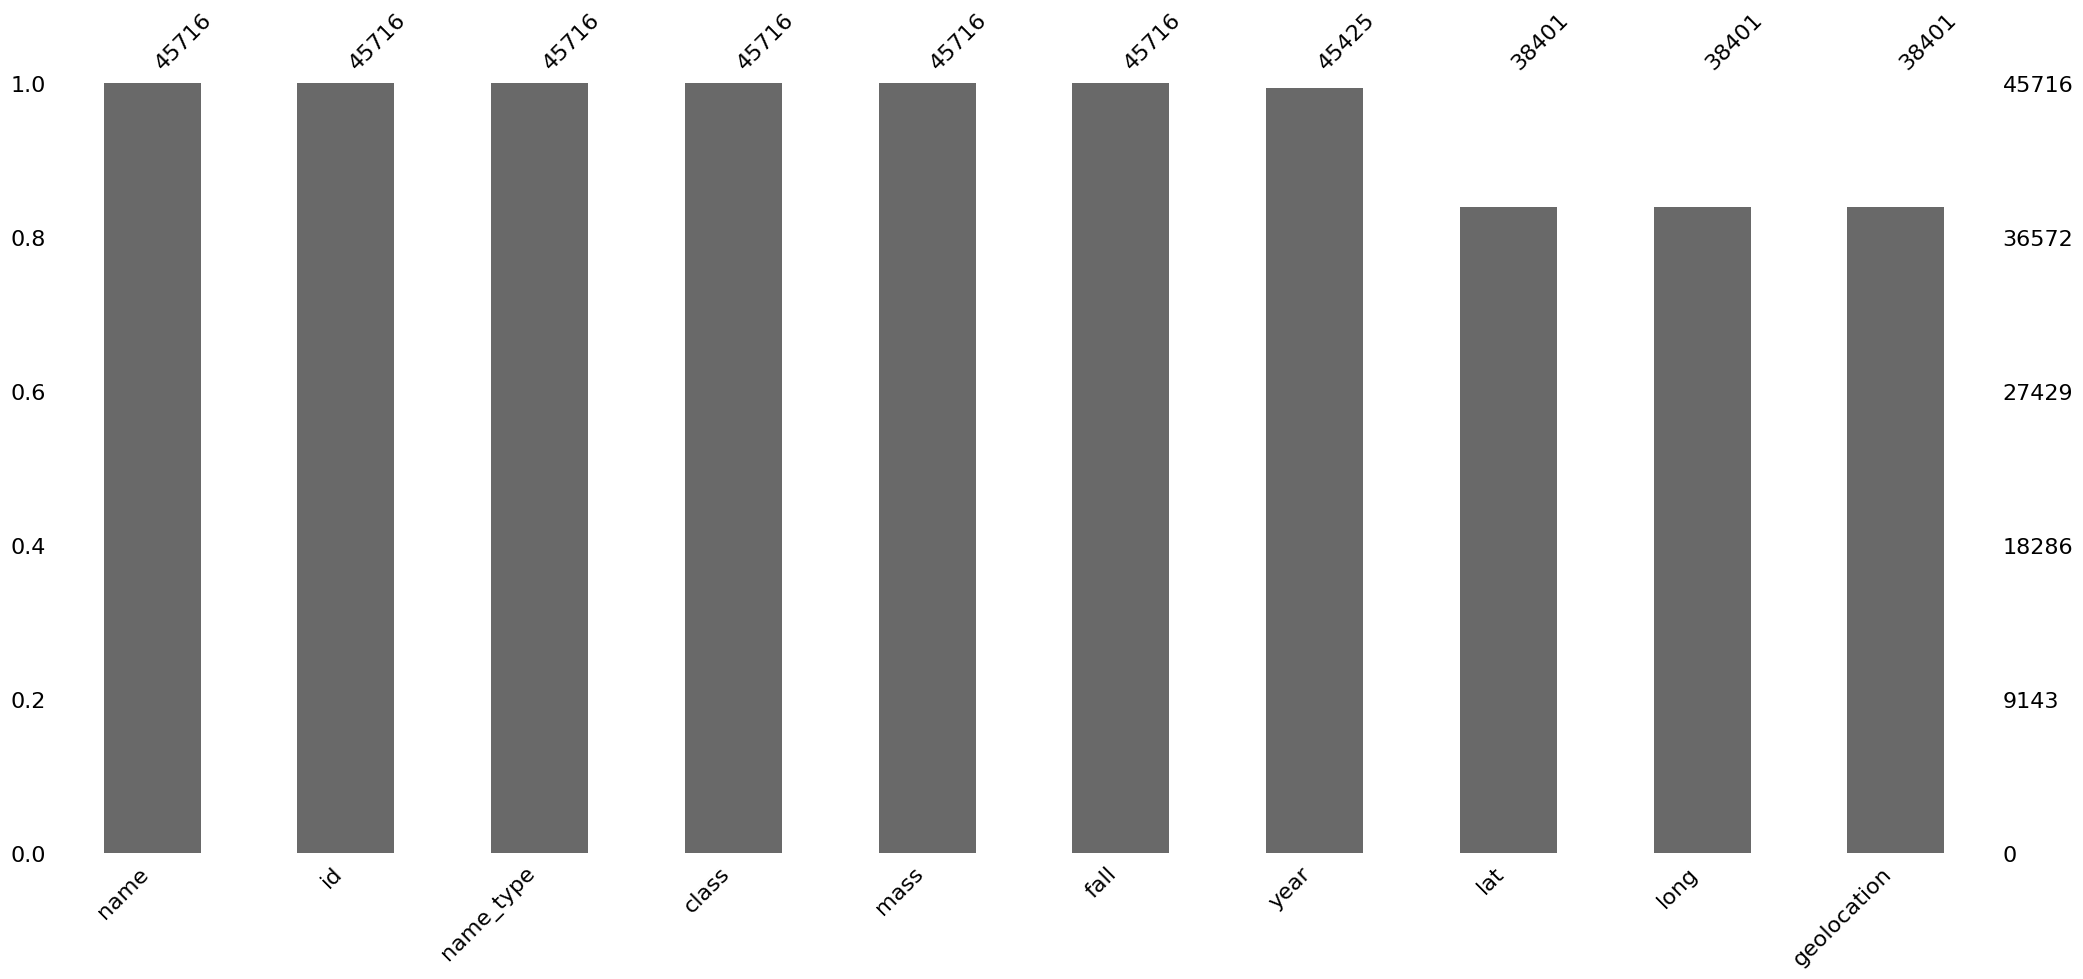

In [23]:
# Display a bar graph of total values in each column, 
msno.bar(df)

Based on the nature of this dataset, there is a decent amount of variation in missing values. So imputation and datadrop techniques will entirely depend on the type of analysis being conducted. Fortunately latitude and longitude have the exact same amount of missing values leading to a reasonable conclusion that these values are not missing due to random input omission, rather they are missing simply due to NASA not knowing the exact coordinates of the fallen meteorite. 

In [24]:
# Fill all missing values and update the current dataframe
df['mass'].fillna(df['mass'].mean(), inplace=True) # fill with the average mass
df['year'].fillna(df['year'].mode()[0], inplace=True) # fill with the most common value
df['lat'].fillna(df['lat'].mode()[0], inplace=True) # fill with the most common value
df['long'].fillna(df['long'].mode()[0], inplace=True) # fill with the most common value
df['geolocation'].fillna(df['geolocation'].mode()[0], inplace=True) # fill with the most common value

In [25]:
# Take another look to make sure that all missing values have been dealt with
df.isnull().sum()

name           0
id             0
name_type      0
class          0
mass           0
fall           0
year           0
lat            0
long           0
geolocation    0
dtype: int64

#### Outlier Detection

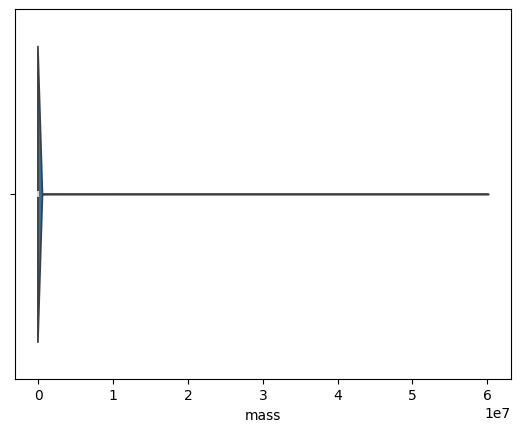

In [26]:
sns.violinplot(data=df, x='mass')
plt.show()

#### Normalizing
The violin plot displayed above shows some very heavy outliers as the actual internal boxplot and density plot is completely uninterpretable. Normalizing the dataset will help mitigate this issue. Since min-max normalization is sensitive to outliers, standard scaling using Z-Score normalization should result in a more robust method.

In [27]:
# Z-Score Normalization
mass_column = df[['mass']]
standard_scaler = StandardScaler()
df['mass_zscore'] = standard_scaler.fit_transform(mass_column)

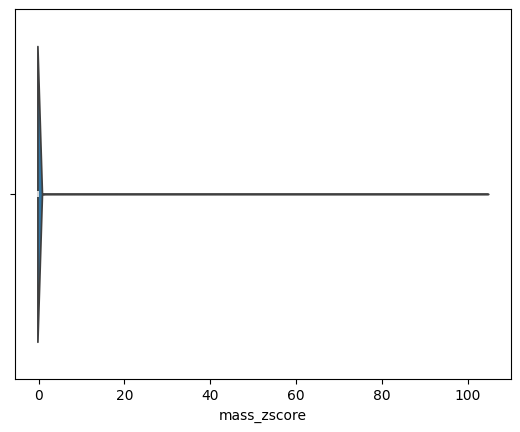

In [28]:
sns.violinplot(data=df, x='mass_zscore')
plt.show()

The mass feature is clearly a case of extreme outliers and standard normalization will not be enough, applying a log transformation on the mass column before normalizing will help mitigate the impact of extremely large values to give a stronger and more normalized dataset.

In [29]:
# Apply a natural logarithm to the mass column before applying a Z-Score noramlization
df['mass_log'] = np.log1p(df['mass'])

# Apply Z-score normalization to the log-transformed values
standard_scaler = StandardScaler()
df['mass_log_scaled'] = standard_scaler.fit_transform(df[['mass_log']])

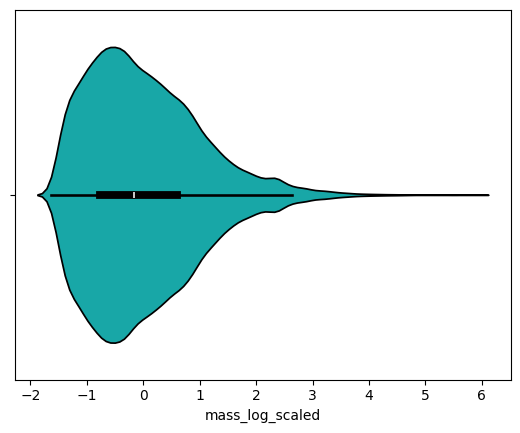

In [30]:
# Now let's reevaluate the violin plot to see the distribution again 
sns.violinplot(data=df, x='mass_log_scaled', color='c', linecolor='k')
plt.show()

Much better. We can see the distribution density and boxplot of the masses a lot more clearly. 

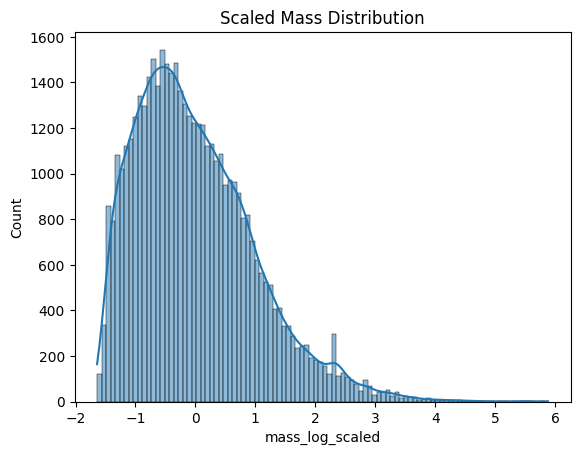

In [31]:
# Create a histogram of the normalized/log-scaled mass, it looks like the mode is slightly less the median
sns.histplot(data=df, x='mass_log_scaled', kde=True)
plt.title("Scaled Mass Distribution")
plt.show()

## Feature Engineering

In [32]:
# Assign every row a 1 to represent that a meteorite was discovered  
df['discovered'] = 1
df.head()

name   id name_type        class      mass  fall    year       lat  \
0    Aachen    1     Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2     Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6     Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10     Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370     Valid           L6     780.0  Fell  1902.0 -33.16667   

        long           geolocation  mass_zscore   mass_log  mass_log_scaled  \
0    6.08333     (50.775, 6.08333)    -0.023099   3.091042        -0.345685   
1   10.23333  (56.18333, 10.23333)    -0.021882   6.580639         1.120485   
2 -113.00000    (54.21667, -113.0)     0.163224  11.580593         3.221238   
3  -99.90000     (16.88333, -99.9)    -0.019802   7.557473         1.530906   
4  -64.95000   (-33.16667, -64.95)    -0.021777   6.660575         1.154070   

   discovered  
0           1  
1           1  
2           1  
3           1  
4           1

In [33]:
# Sum the total rows for each year
total_discovered_per_year = df.groupby('year')['discovered'].sum().reset_index()

# Filter data for years 1958 and above (when NASA was founded)
total_discovered_per_year = total_discovered_per_year[total_discovered_per_year['year'] >= 1958]

print(total_discovered_per_year.head(5))
print(total_discovered_per_year.tail(5))

       year  discovered
208  1958.0          18
209  1959.0          16
210  1960.0          30
211  1961.0          27
212  1962.0          36
       year  discovered
259  2009.0        1497
260  2010.0        1006
261  2011.0         713
262  2012.0         234
263  2013.0          11


Since 2013 is such a large outlier and will be very hard to see visually, it will be dropped for model creation and testing. 

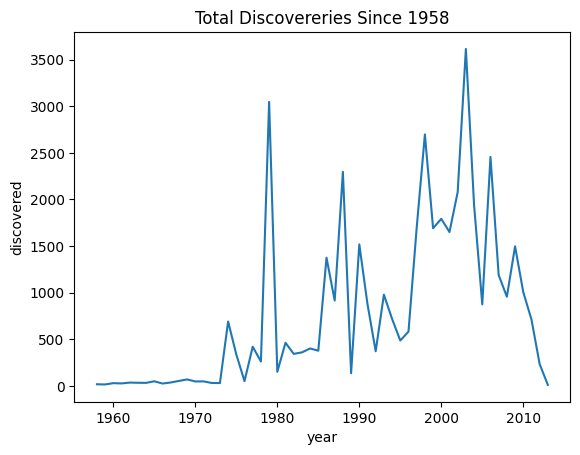

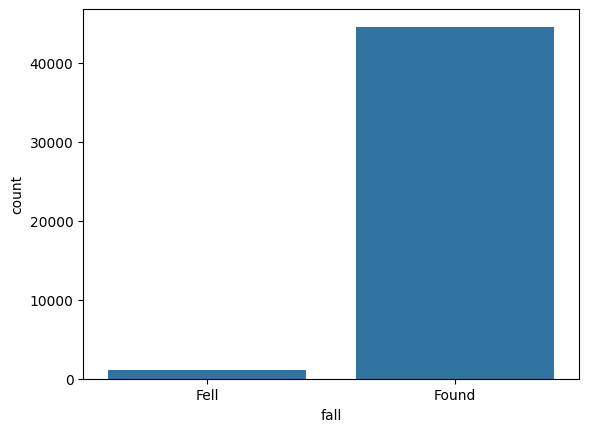

In [34]:
# Apply a natural logatrithm to the total discovery counts for each year
total_discovered_per_year['discovered_log'] = np.log1p(total_discovered_per_year['discovered'])

# Apply Z-score normalization to the log-transformed values
standard_scaler = StandardScaler()
total_discovered_per_year['discovered_log_scaled'] = standard_scaler.fit_transform(total_discovered_per_year[['discovered_log']])

sns.lineplot(data=total_discovered_per_year, x="year", y="discovered")
plt.title('Total Discovereries Since 1958')
plt.show()
plt.clf()

sns.countplot(x='fall',data=df)
plt.show()

#### Interpretation
What does this time series analysis mean in the context of this dataset? It goes back to the fell or found variable. If NASA is recording every time a meteorite is found, no matter how long ago it impacted with the Earth, then logically the amount of found meteorites will drop dramatically over the years since there are less and less to be discovered. 

## Machine Learning

#### XGBoost
Let's try and visualize this pattern using XGBoost Regression to see the downward trend in total discovered meteorites.

C:\Users\Elijah Taber\AppData\Local\Temp\ipykernel_25780\3336993411.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Range of discovered values: 3603.0


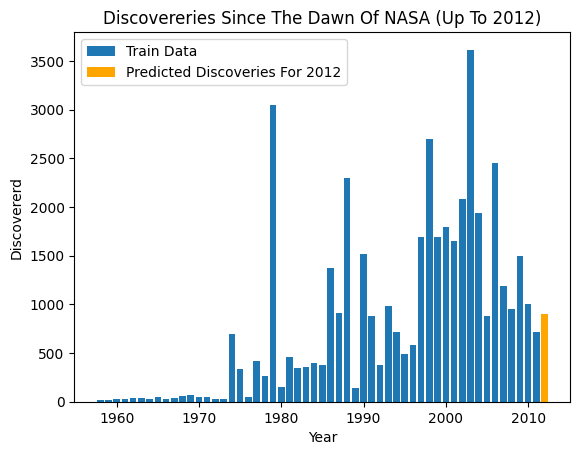

In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Split the data into training (1958 to 2011) and testing (2012) sets
train_data = total_discovered_per_year[total_discovered_per_year['year'] < 2012]
test_data = total_discovered_per_year[total_discovered_per_year['year'] == 2012]

# Define the training values
X_train = train_data['year'].values.reshape(-1, 1)
y_train = train_data['discovered_log_scaled']

# Define the testing values
X_test = test_data['year'].values.reshape(-1, 1)
y_test = test_data['discovered_log_scaled']

# Define specific XGBoost parameters to prevent overfitting
params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'gamma': 0.1,
}

# Create the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=10, **params)
xgb_model.fit(X_train, y_train) # train the model

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

print("Range of discovered values:", total_discovered_per_year.max()[1] - total_discovered_per_year.min()[1])

# Inverse transform the predicted values to revert them back to their original scale
y_pred_original_scale = np.expm1(standard_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten())

# Visualize the model by plotting training data and test data
plt.bar(train_data['year'], train_data['discovered'], label='Train Data')
plt.bar(test_data['year'], y_pred_original_scale, label='Predicted Discoveries For 2012', color='orange')
plt.xlabel('Year')
plt.ylabel('Discovererd')
plt.title('Discovereries Since The Dawn Of NASA (Up To 2012)')
plt.legend(loc='upper left')
plt.show()

#### Validation

In [36]:
# Define a kfold object to split the XGBoost model into 5 separate folds
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

# Create a Cross Validation function to score the model
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive values by calculating the root mean square
rmse_scores = (-scores)**0.5

# Evaluate the cross-validated RMSE scores
print("Cross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())

Cross-validated RMSE scores: [0.61588021 0.41849076 0.63588454 0.56351799 0.34791331]
Mean RMSE: 0.5163373617567083


In [37]:
# Creates a function to evaluate the performance of the model
def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Squarred Error
    mse = mean_squared_error(y_true, y_pred)
        
    return {'Mean Absolute Error': mae,
           'Mean Squarred Error': mse}

evaluation_results = evaluate_model(xgb_model, X_test, y_test)

for metric, value in evaluation_results.items():
    print(f'{metric}: {value:.2f}')

Mean Absolute Error: 0.81
Mean Squarred Error: 0.65


In [38]:
# A lower mae means better perfromance, but what does this mean in the context of this data set
print("MAE variance accountability:", round((0.81 / 3603), 6)) # the mae score divided by the range of discovered values

MAE variance accountability: 0.000225


#### Interpretation
Given the large range of variance in the discovery values for each year (3603) and an mae score of 0.81, the normalized score of 0.023% means that, on average, the model's predictions has a very small error compared to the range of the target variable. Given the nature of this dataset and the large amount of variation in yearly discoveries, an MAE score of 0.81 and MSE score of 0.65 is quite respectable. This model does well in accounting for the variation in discovered meteorites and then following the trend downwards towards a logical outcome. Additional hyperparameter tuning is recommended to further increase the output score of this model.

## Complete Global Distribution of NASA Meteorites
This will display a full global distribution for each meteorite along with it's statistics when hovered over. 

In [39]:
# This animation is computationally expensive, remove quotes and run to interact with each meteorite
"""
fig_map = px.scatter_geo(
    animation_df,
    lat='lat',
    lon='long',
    title='Global Distribution of Meteorites',
    projection='natural earth', 
    hover_name='name', 
    size='mass', 
    template='plotly_dark',
)

fig_map.show()
"""

"\nfig_map = px.scatter_geo(\n    animation_df,\n    lat='lat',\n    lon='long',\n    title='Global Distribution of Meteorites',\n    projection='natural earth', \n    hover_name='name', \n    size='mass', \n    template='plotly_dark',\n)\n\nfig_map.show()\n"

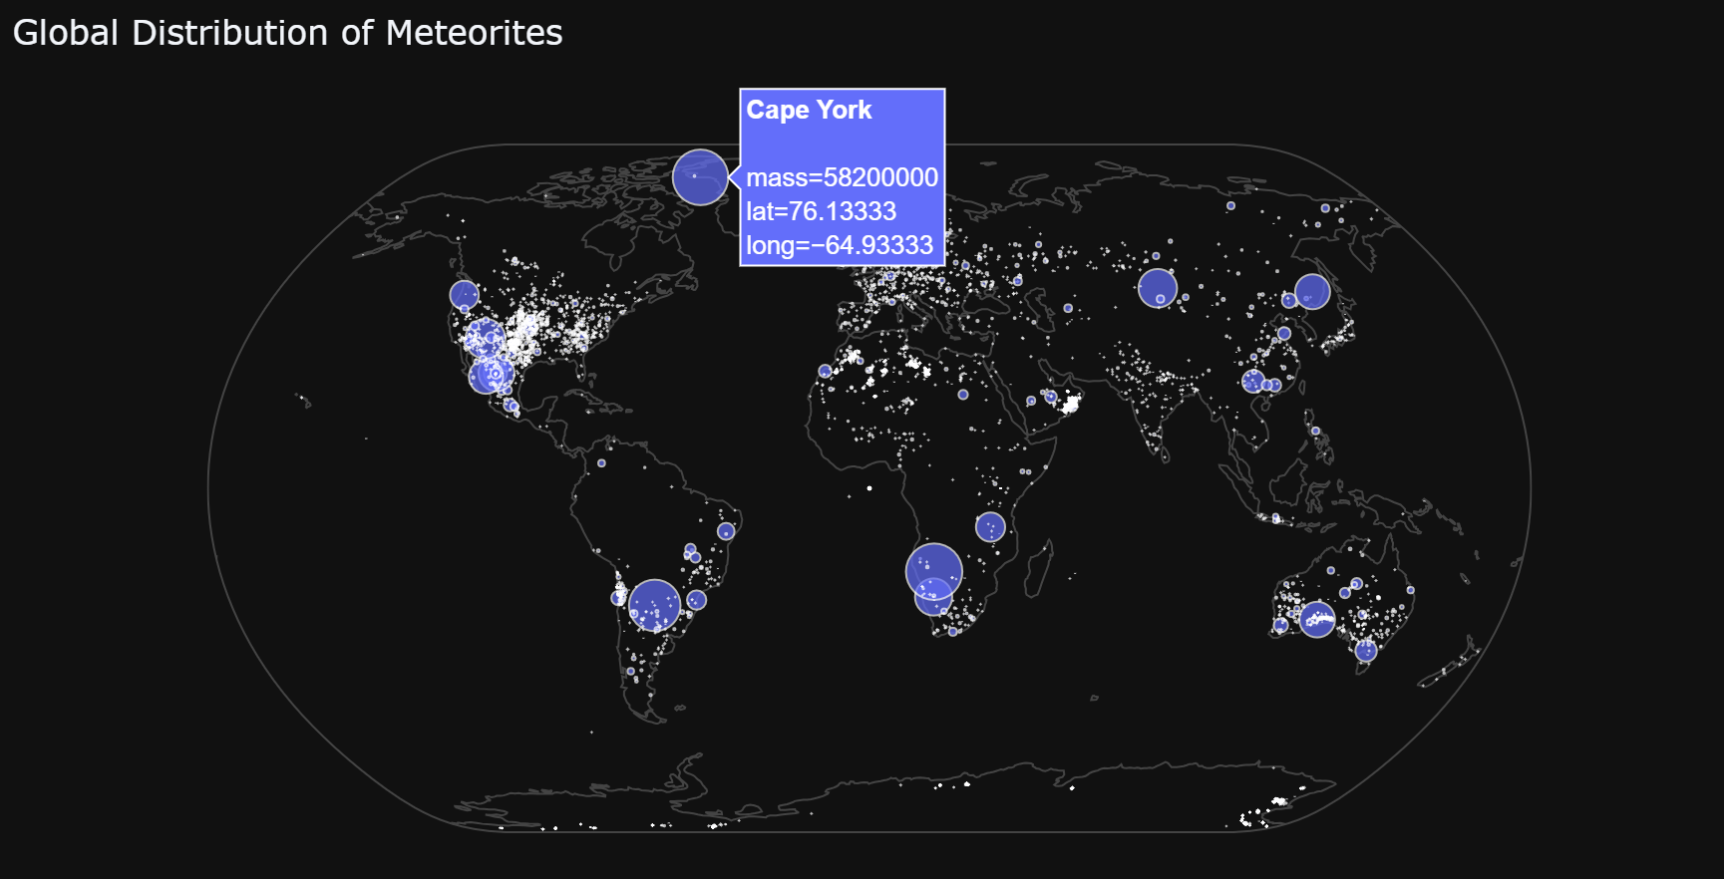

In [42]:
# Screenshot of global distribution with labeled masses and geospatial coordinates
from IPython.display import display, Image

image_path = "C:\\Users\\Elijah Taber\\Downloads\\Projects\\NASA Meteorites\\images\\Global Mass Distribution.png"
display(Image(filename=image_path))